<a href="https://colab.research.google.com/github/Tclack88/MatlabSucks/blob/main/eng_mech/Instron_compression_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from shapely.geometry import LineString

In [ ]:
!pip install xlrd==1.2

In [ ]:
al_dat = "https://raw.githubusercontent.com/Tclack88/MatlabSucks/main/eng_mech/G04/M2_G4W4_Al_1.csv"
cer_dat = "https://raw.githubusercontent.com/Tclack88/MatlabSucks/main/eng_mech/G04/M2_G4W4_Cer_1.csv"
pvc_dat = "https://raw.githubusercontent.com/Tclack88/MatlabSucks/main/eng_mech/G04/M2_G4W4_%20PVC_1.csv"

temp_al_dat = 'https://github.com/ProfessorKazarinoff/staticsite/raw/master/content/code/matplotlib_plots/stress_strain_curves/aluminum6061.xls'

old_cols = ['Compressive displacement', 'Primary force measurement', 'Time measurement']
new_cols = ['disp', 'force', 'time'] # given in displacement (mm), force (kN), time (s)
cols = dict(zip(old_cols, new_cols))

In [ ]:
# !wget temp_al_dat
new_al = pd.read_excel(temp_al_dat)
new_al
new_al = new_al[['POSIT','FORCE', 'EXT']]
new_al.columns = ['disp','force', 'strain']
new_al.force = 0.0044482216*new_al.force*1000 # convert lb to N
new_al.disp = 25.4*new_al.disp # convert inches to mm
new_al.strain = .01*new_al.strain # change percent to decimal

new_al_d = .506*25.4 # mm to inches 
new_al

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,disp,force,strain
0,0.387096,894.797622,0.000189
1,0.406400,916.236318,0.000003
2,0.436880,975.474716,-0.000009
3,0.596900,1194.373699,0.000015
4,0.763016,1432.452651,0.000019
...,...,...,...
195,16.962627,36399.560607,0.030071
196,17.022064,36136.978697,0.030071
197,17.061687,35918.909412,0.030071
198,17.100803,35672.100444,0.030071


In [ ]:
# tabularize specimen data
al = pd.read_csv(al_dat)[1:].rename(columns = cols).astype(float)
pvc = pd.read_csv(pvc_dat)[1:].rename(columns = cols).astype(float)
cer = pd.read_csv(cer_dat)[1:].rename(columns = cols).astype(float)

# change Force to SI units (no change to length because it will be cancelled)
al.force = al.force*1000
pvc.force = pvc.force*1000
cer.force = cer.force*1000

# measurements (lengths and diameters in mm)
al_l = 17.80
al_d = 11.93

cer_l = 24.93
cer_d = 11.45
cer_di1 = 4.05
cer_di2 = 4.08

pvc_l = 40.74
pvc_d = 21.06



def Area(d):
  # given diameter (mm), returns area in m^2
  return pi*(.001*d/2)**2

A_al = Area(al_d)
A_pvc = Area(pvc_d)
A_cer = Area(cer_d) - Area(cer_di1) - Area(cer_di2) # subtract areas from holes

A_new_al = Area(new_al_d)

al.head()

,disp,force,time
1,0.00000,0.09,0.00
2,0.00005,0.42,0.02
3,0.00027,0.39,0.04
4,0.00095,0.21,0.06
5,0.00139,-0.16,0.08


In [ ]:
# find stress in MPa
al['stress'] = al.force/A_al/1e6
pvc['stress'] = pvc.force/A_pvc/1e6
cer['stress'] = cer.force/A_cer/1e6
# find strain. unitless
al['strain'] = al.disp/al_l
pvc['strain'] = pvc.disp/pvc_l
cer['strain'] = cer.disp/cer_l

new_al['stress'] = new_al.force/A_new_al/1e6

al.head()

,disp,force,time,stress,strain
1,0.00000,0.09,0.00,0.000805,0.000000
2,0.00005,0.42,0.02,0.003757,0.000003
3,0.00027,0.39,0.04,0.003489,0.000015
4,0.00095,0.21,0.06,0.001879,0.000053
5,0.00139,-0.16,0.08,-0.001431,0.000078


In [ ]:
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sb.set_theme(style='ticks', rc=custom_params)

# plot = sb.lineplot(x=al.strain, y=al.stress);
# plot.set(title='Stress-Strain Relation of Aluminum Sample');
# plot.set(ylabel='stress (MPa)');

# plot = sb.lineplot(x=new_al.strain, y=new_al.stress);
# plot.set(title='Stress-Strain Relation of NEW Aluminum Sample');
# plot.set(ylabel='stress (MPa)');

# plot = sb.lineplot(pvc.strain, pvc.stress);
# plot.set(title='Stress-Strain Relation of PVC Sample');
# plot.set(ylabel='stress (MPa)');

# plot = sb.lineplot(cer.strain,cer.stress);
# plot.set(title='Stress-Strain Relation of Ceramic Sample');
# plot.set(ylabel='stress (MPa)');

In [ ]:
def find_neighbor(col, val):
  # returns an row with a col very close to the given value
  for i,value in enumerate(col):
    if value >= val:
      break
  return i

def youngs_modulus(dat, low, high):
  # Given dataframat (dat), and two values for STRESS (low and high) obtained from inspection
  # this will return the slope, i.e. young's modulus
  row1 = find_neighbor(dat.stress, low) # get index of column containing ~ low estimate
  row2 = find_neighbor(dat.stress, high) # get index of column containing ~ high estimate

  rise = dat.loc[row2,:].stress - dat.loc[row1,:].stress
  run = dat.loc[row2,:].strain - dat.loc[row1,:].strain
  E = rise/run # young's modulus = slope
  # get y intercept
  b = dat.loc[row2,:].stress - E*(dat.loc[row2,:].strain) # b = y - mx
  return E, b


E_al, b_al = youngs_modulus(al, 50, 150)
E_pvc, b_pvc = youngs_modulus(pvc, 10, 70)
E_cer, b_cer = youngs_modulus(cer, 100, 600)

# E_new_al = youngs_modulus(new_al,50,250)

print(f'Al - {round(E_al,2)} MPa')    # expected 70 GPa (70000 Mpa)
print(f'pvc - {round(E_pvc,2)} MPa')  # 3275 Mpa expected
print(f'cer - {round(E_cer,2)} MPa')  # 215-413 Gpa expected (215000 - 413000 Mpa

# print(f'new Al - {round(E_new_al,2)} MPa')    # expected 70 GPa (70000 Mpa)


Al - 6870.29 MPa
pvc - 2424.6 MPa
cer - 25732.28 MPa



Yield strength for Aluminum- 172.34 MPa
Modulus of resiliance for Metal:
	2.82 Mpa - using yield stress and yield strain
	2.16 MPa - using yield stress and modulus of elasticity

Yield strength for PVC- 79.82 MPa


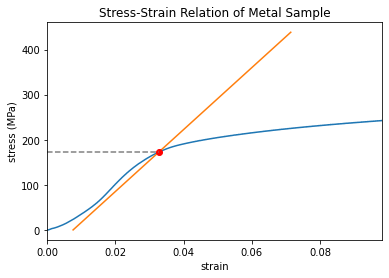

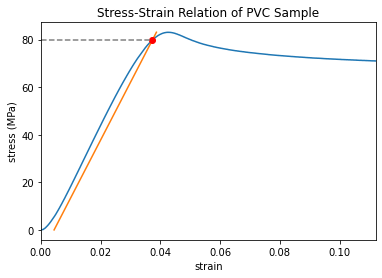

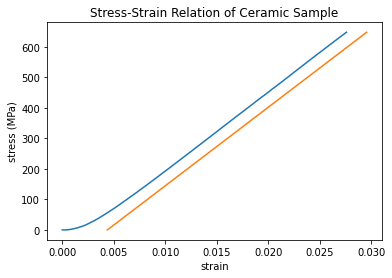

In [ ]:
# Add columns x-range and y-range for .2% yield line
for dat, E, b in [(al,E_al, b_al), (pvc,E_pvc,b_pvc), (cer,E_cer,b_cer)]:
  y_range = np.linspace(0,max(dat.stress),len(dat.stress))
  x_range = (y_range - b)/E + .002 # use point slope form to get x's then add .2% shift
  dat['xrange'] = x_range
  dat['yrange'] = y_range


for mat, dat in [('Aluminum', al), ('PVC', pvc), ('Ceramic', cer)]:
  # Calculate yield strength
  # Use young's modulus slope starting from .2% displacement (.002 yield)
  # find intersection of this curve and stress-strain curve to find yield strength
  fig, ax = plt.subplots()
  ax = sb.lineplot(x=dat.strain, y=dat.stress);
  ax1 = sb.lineplot(x=dat.xrange, y=dat.yrange);
  line1 = LineString(np.column_stack((dat.strain,dat.stress)))
  line2 = LineString(np.column_stack((dat.xrange,dat.yrange)))
  try:
    intersection = line1.intersection(line2)
    ax.plot(*intersection.xy, 'ro')
    x_int = intersection.xy[0][0]
    y_int = intersection.xy[1][0]
    ax.plot(np.linspace(0,x_int,100),np.ones(100)*y_int,'--', color='grey')
    ax.set_xlim(0,3*x_int) # arbitrary choice. Makes the line separation a little larger
    # ax.set_ylim(0,1.2*y_int)
    ax.set(ylabel='stress (MPa)');
    ax.set(title=f'Stress-Strain Relation of {mat} Sample');
    print(f'\nYield strength for {mat}- {round(y_int,2)} MPa')
    if mat == 'Aluminum':
      U = round(x_int*y_int/2,2)
      U2 = round(y_int**2/(2*E_al),2)
      print(f'Modulus of resiliance for Metal:\n\t{U} Mpa - using yield stress and yield strain\n\t{U2} MPa - using yield stress and modulus of elasticity')
      ax.set(title=f'Stress-Strain Relation of Metal Sample');
    dir(intersection.xy[1])
  except:
    ax.set(ylabel='stress (MPa)');
    ax.set(title=f'Stress-Strain Relation of {mat} Sample');
